# Tutorial for BayBooNE: Baysian Booster Neutrino Experiment python package


This package is designed to use Bayesian parameter estimation to find sterile neutrino oscillation parameters ($\Delta m_{14}^2, sin^2 2\theta_{14}$) from a data sample containing initial muon neutrino flux and number of electron neutrinos detected at a particular neutrino energy.

To do so, we first simulate a short-baseline neutrino oscillation dataset for a particular ($\Delta m^2, sin^2 2\theta$) pair, and then use a pymc3-based algorithm to infer the parameters from our simulated data.

In [18]:
# Pacakge dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns

# Inference package componenets
import bayboone.data_io as makeData
from bayboone.inference import module as ifunc

#Allows reimporting the package without restarting the kernel
import importlib

## Create a sample dataset by simulating data based on our generative model.

The generative model draws from known values of neutrino energy E, distance from detector L, to calculate numu to nue oscillation probability, and then adjusts for overall flux (in progress). 

Importantly, we use $$ P_{\nu_{\mu} -> \nu_{e-}} = sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E})$$ To get the oscillation probability, and multiply that by the number of muon neutrinos to get our expected electron neutrino signal. $$\#\nu_{e-} = \#\nu_{mu}\times P_{\nu_{\mu} -> \nu_{e-}}$$



In [19]:
# To simulate a sample number of nues detected in a microboone-like experiment
# Arguments are number of muon nuetrinos sent by the beam, sin^2_2theta, delta_m^2
uboone_data = makeData.simulate_microboone(600000, 0.1, 1)

# To simulate a sample from a generic detector
# Arguments are number of numus, sin^2_2theta, delta_m^2, detector baseline L, neutrino energy E, uncertainty in L, uncertainty in E
generic_data = makeData.simulate_detector(100000, 0.7, 4, 0.5, 1, 0.1, 10e-3)
# These values were chosen to illustrate the shape of the model, rather than to be realistic

AttributeError: module 'bayboone.data_io' has no attribute 'simulate_microboone'


## Infer $\Delta m^2$ and $sin^2 2\theta$ from the data created by our model.

We make use of three functions from our inference_functions pacakge (imported here as ifunc):

-  oscillation_model: sets up our model in pymc3
-  fit_model: fits data to the statistical model
-  print_fit_vals: returns the fit values and uncertainties on our parameters

In [20]:
importlib.reload(ifunc)
ifunc.oscillation_model(600000, 10)
# nue_Flux should be drawn from a Beta distribution, but we're dealing with a problem in pymc3 
# which prevents the code from running succesfully do to pymc3 choosing guess values excluded by the priors. 

In [11]:
data = [600000, 10]
best_fit, cov = ifunc.fit_model(data)

In [17]:
best_fit


{'sin^2_2theta': array([-0.82411586]),
 'delta_m^2': array([0.84691428]),
 'L': array([0.2298972]),
 'E': array([1.07001828]),
 'prediction': array([-0.04323294])}

In [12]:
ifunc.print_fit_vals(best_fit, cov)
#NB: This does not report the marginalized values, but rather the general best-fit values

,value,uncertainty
sin^2_2theta,-0.824116,2.213600
delta_m^2,0.846914,5.705529
00000000000000,0.000000,0.000000
00000000000000,0.000000,0.000000


In [13]:
print(best_fit)

{'sin^2_2theta': array([-0.82411586]), 'delta_m^2': array([0.84691428]), 'L': array([0.2298972]), 'E': array([1.07001828]), 'prediction': array([-0.04323294])}


In [15]:
P = best_fit['sin^2_2theta']*np.sin(best_fit['delta_m^2']*best_fit['L']/best_fit['E'])**2
predicted_num_nues = data[0]*P
print("the parameters estimated predict "+ str(predicted_num_nues) + " electron neutrinos, compared to "+str(data[1])+" observed")

the parameters estimated predict [-16192.16327347] electron neutrinos, compared to 10 observed


In [13]:
plt.scatter(L_over_E, best_fit['prediction'] , label='model fit')
plt.scatter(L_over_E, data['N_nue'] , label='generated data')

plt.xlabel('L/E (m/GeV)')
plt.ylabel('Probability of numu -> nue')
plt.legend()

NameError: name 'L_over_E' is not defined

(-0.1, 0.1)

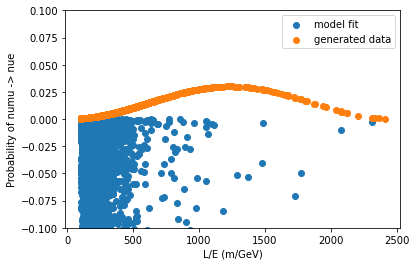

In [13]:
plt.scatter(L_over_E, best_fit['prediction'] , label='model fit')
plt.scatter(L_over_E, data['N_nue'] , label='generated data')

plt.xlabel('L/E (m/GeV)')
plt.ylabel('Probability of numu -> nue')
plt.legend()
ax =  plt.gca()
ax.set_ylim(-0.1, 0.1)

/home/jybook/anaconda3/envs/phys201b/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E, L, delta_m^2, sin^2_2theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 94 seconds.
There were 882 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6153538392551477, but should be close to 0.8. Try to increase the number of tuning steps.
There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1045 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4360134816321, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


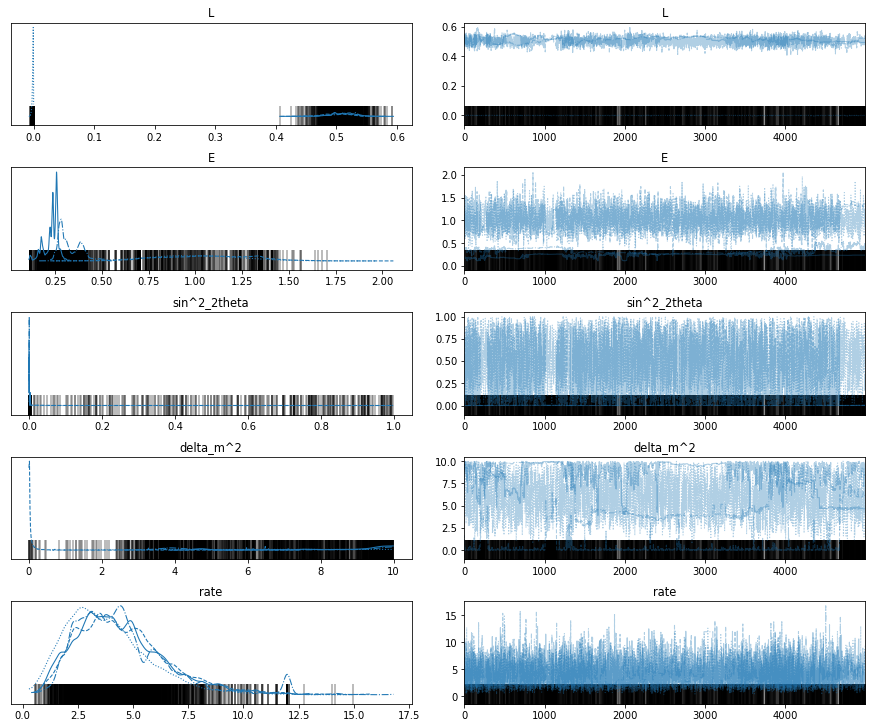

In [21]:
importlib.reload(ifunc)
data = [60000, 4]
#After merge, should be able to use data as defined above instead of the points
#The points here should correspond to dms = 1eV^2, ss2t = 0.5
trace = ifunc.new_fit_model(data)

In [22]:
df_trace = pm.trace_to_dataframe(trace)

In [23]:
trace

<MultiTrace: 4 chains, 5000 iterations, 7 variables>

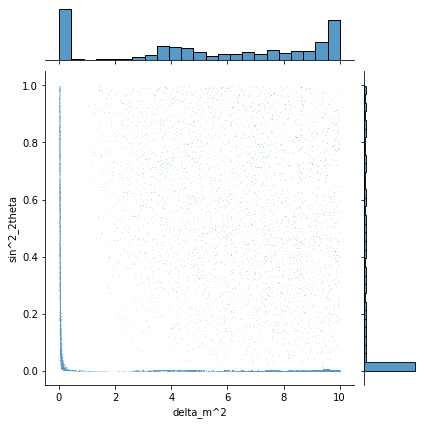

In [24]:
joint_kde = sns.jointplot(x='delta_m^2', y='sin^2_2theta', data=df_trace, kind='scatter', s=0.2)

In [15]:
q = df_trace.quantile([0.16,0.50,0.84], axis=0)
print("delta_m^2 = {:.2f} + {:.2f} - {:.2f}".format(q['delta_m^2'][0.50], 
                                            q['delta_m^2'][0.84]-q['delta_m^2'][0.50],
                                            q['delta_m^2'][0.50]-q['delta_m^2'][0.16]))
print("sin^2_2theta = {:.1f} + {:.1f} - {:.1f}".format(q['sin^2_2theta'][0.50], 
                                            q['sin^2_2theta'][0.84]-q['sin^2_2theta'][0.50],
                                            q['sin^2_2theta'][0.50]-q['sin^2_2theta'][0.16]))


delta_m^2 = 6.78 + 2.38 - 6.75
sin^2_2theta = 0.1 + 0.6 - 0.1
